# Testing Compilers

In this chapter, we will make use of [grammars and grammar-based testing](Grammars.ipynb) to systematically generate _program code_ – for instance, to test a compiler or an interpreter. Not very surprisingly, we use _Python_ and the _Python interpreter_ as our domain.

We chose Python not only because the rest of the book is also based on Python.
Most importantly, Python brings lots of built-in infrastructure we can leverage, especially

* _parsers_ that convert Python code into an abstract syntax tree (AST) representation and 
* _unparsers_ that take an AST and convert it back into Python code.

This allows us to leverage grammars that operate on ASTs rather than concrete syntax, greatly reducing complexity.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('Nr1xbKj_WRQ')

**Prerequisites**

* You must read the chapter on [Fuzzing with Grammars](Grammars.ipynb) to understand how grammars and grammar-based testing work.

In [2]:
# ignore
import sys

In [3]:
# ignore
if sys.version_info < (3, 10):
    print("This code requires Python 3.10 or later")
    sys.exit(0)

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.PythonFuzzer import <identifier>
```

and then make use of the following features.


This chapter provides a `PythonFuzzer` class that allows producing arbitrary Python code elements:

```python
>>> fuzzer = PythonFuzzer()
>>> print(fuzzer.fuzz())
def Hw(): # type: 
    pass

```
By default, `PythonFuzzer` produces a _function definition_ – that is, a list of statements as above.
You can pass a `start_symbol` argument to state which Python element you'd like to have:

```python
>>> fuzzer = PythonFuzzer('<While>')
>>> print(fuzzer.fuzz())
while 
'' or {Z: *(set() ^ set())}:
    del 

```
Here is a list of all possible start symbols. Their names reflect the nonterminals from the [Python `ast` module documentation](https://docs.python.org/3/library/ast.html).

```python
>>> sorted(list(PYTHON_AST_GRAMMAR.keys()))
['<Assert>',
 '<Assign>',
 '<Attribute>',
 '<AugAssign>',
 '<BinOp>',
 '<BoolOp>',
 '<Break>',
 '<Call>',
 '<Compare>',
 '<Constant>',
 '<Continue>',
 '<Delete>',
 '<Dict>',
 '<EmptySet>',
 '<Expr>',
 '<For>',
 '<FunctionDef>',
 '<If>',
 '<List>',
 '<Module>',
 '<Name>',
 '<Pass>',
 '<Return>',
 '<Set>',
 '<Slice>',
 '<Starred>',
 '<Subscript>',
 '<Tuple>',
 '<UnaryOp>',
 '<While>',
 '<With>',
 '<arg>',
 '<arg_list>',
 '<args>',
 '<arguments>',
 '<bool>',
 '<boolop>',
 '<cmpop>',
 '<cmpop_list>',
 '<cmpops>',
 '<digit>',
 '<digits>',
 '<expr>',
 '<expr_list>',
 '<exprs>',
 '<float>',
 '<func>',
 '<id>',
 '<id_continue>',
 '<id_start>',
 '<identifier>',
 '<integer>',
 '<keyword>',
 '<keyword_list>',
 '<keywords>',
 '<kwarg>',
 '<lhs_Attribute>',
 '<lhs_List>',
 '<lhs_Name>',
 '<lhs_Starred>',
 '<lhs_Subscript>',
 '<lhs_Tuple>',
 '<lhs_expr>',
 '<lhs_exprs>',
 '<literal>',
 '<mod>',
 '<none>',
 '<nonempty_expr_list>',
 '<nonempty_lhs_expr_list>',
 '<nonempty_stmt_list>',
 '<nonzerodigit>',
 '<not_double_quotes>',
 '<not_single_quotes>',
 '<operator>',
 '<returns>',
 '<start>',
 '<stmt>',
 '<stmt_list>',
 '<stmts>',
 '<string>',
 '<type_comment>',
 '<type_ignore>',
 '<type_ignore_list>',
 '<type_ignores>',
 '<unaryop>',
 '<vararg>',
 '<withitem>',
 '<withitem_list>',
 '<withitems>']
```
If you'd like more control over Python code generation, here is what is happening behind the scenes.
The EBNF grammar `PYTHON_AST_GRAMMAR` can parse and produce _abstract syntax trees_ for Python.
To produce a Python module without `PythonFuzzer`, you would take these steps:

**Step 1:** Create a non-EBNF grammar suitable for `ISLaSolver` (or any other grammar fuzzer):

```python
>>> python_ast_grammar = convert_ebnf_grammar(PYTHON_AST_GRAMMAR)
```
**Step 2:**  Feed the resulting grammar into a grammar fuzzer such as ISLa:

```python
>>> solver = ISLaSolver(python_ast_grammar, start_symbol='<FunctionDef>')
```
**Step 3:**  Have the grammar fuzzer produce a string. This string represents an AST.

```python
>>> ast_string = str(solver.solve())
>>> ast_string
'FunctionDef(name=\'t\', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Break()], decorator_list=[], returns=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), type_comment=\'\')'
```
**Step 4:**  Convert the AST into an actual Python AST data structure.

```python
>>> from ast import *
>>> abstract_syntax_tree = eval(ast_string)
```
**Step 5:** Finally, convert the AST structure back into readable Python code:

```python
>>> ast.fix_missing_locations(abstract_syntax_tree)
>>> print(ast.unparse(abstract_syntax_tree))
def t() -> set(): # type: 
    break

```
The chapter has many more applications, including parsing and mutating Python code, evolutionary fuzzing, and more.

Here are the details on the `PythonFuzzer` constructor:

<p><code>PythonFuzzer(self, start_symbol: Optional[str] = None, *, grammar: Optional[Dict[str, List[Union[str, Tuple[str, Dict[str, Any]]]]]] = None, constraint: Optional[str] = None, **kw_params) -&gt; None</code></p>
<p>Produce Python code. Parameters are:</p>
<ul>
<li><code>start_symbol</code>: The grammatical entity to be generated (default: <code>&lt;FunctionDef&gt;</code>)</li>
<li><code>grammar</code>: The EBNF grammar to be used (default: <code>PYTHON__AST_GRAMMAR</code>); and</li>
<li><code>constraint</code> an ISLa constraint (if any).</li>
</ul>
<p>Additional keyword parameters are passed to the <code>ISLaSolver</code> superclass.</p>

![](PICS/PythonFuzzer-synopsis-1.svg)



## A Grammar for Concrete Code

To _produce_ code, it is fairly easy to write a grammar with _concrete_ syntax. If we want to produce, say, arithmetic expressions, we can easily create a concrete grammar which does precisely that.


In [4]:
import bookutils.setup

In [5]:
from Grammars import Grammar
from Grammars import is_valid_grammar, convert_ebnf_grammar, extend_grammar, trim_grammar

In [6]:
from typing import Optional

We use the [Fuzzingbook format for grammars](https://www.fuzzingbook.org/html/Grammars.html), in which grammars are represented as dictionaries from symbols to lists of expansion alternatives.

In [7]:
EXPR_GRAMMAR: Grammar = {
    "<start>":
        ["<expr>"],

    "<expr>":
        ["<term> + <expr>", "<term> - <expr>", "<term>"],

    "<term>":
        ["<factor> * <term>", "<factor> / <term>", "<factor>"],

    "<factor>":
        ["+<factor>",
         "-<factor>",
         "(<expr>)",
         "<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

In [8]:
assert is_valid_grammar(EXPR_GRAMMAR)

We can use this grammar to produce syntactically valid arithmetic expressions.
We use the [ISLa solver](FuzzingWithConstraints.ipynb) as our generator, as it is the most powerful; but we could also use any other of our grammar fuzzers such as [GrammarFuzzer](GrammarFuzzer.ipynb) at this point.

In [9]:
from isla.solver import ISLaSolver  # type: ignore

Here are some concrete inputs produced from the grammar:

In [10]:
expr_solver = ISLaSolver(EXPR_GRAMMAR)
for _ in range(10):
    print(expr_solver.solve())

4.3 + 512 / -(7 / 6 - 0 / 9 * 1 * 1) * +8.3 / 7 * 4 / 6
(4 / 7 + 1) / (4) / 9 / 8 + 4 / (3 + 6 - 7)
+--(--(-9) * (4 * 7 + (4) + 4) + --(+(3)) - 6 + 0 / 7 + 7)
(2 * 6 + 0 - 5) * 4 - +1 * (2 - 2) / 8 / 6
(+-(0 - (1) * 7 / 3)) / ((1 * 3 + 8) + 9 - +1 / --0) - 5 * (-+939.491)
+2.9 * 0 / 501.19814 / --+--(6.05002)
+-8.8 / (1) * -+1 + -8 + 9 - 3 / 8 * 6 + 4 * 3 * 5
(+(8 / 9 - 1 - 7)) + ---06.30 / +4.39
8786.82 - +01.170 / 9.2 - +(7) + 1 * 9 - 0
+-6 * 0 / 5 * (-(1.7 * +(-1 / +4.9 * 5 * 1 * 2) + -4.2 + (6 + -5) / (4 * 3 + 4)))


We could extend the grammar further to also produce assignments and other statements, and piece by piece cover the entire syntax of the programming language. However, this would be a not-so-great idea. Why?

The problem is that when testing _compilers_, you not only want to be able to _produce_ code, but also to _parse_ code, such that you can mutate and manipulate it at will. And this is where our "concrete" syntax will give us problems. While we can easily parse code (or expressions) that exactly adheres to the syntax...

In [11]:
expr_solver.check('2 + 2')

True

... a single space will already suffice to make it fail...

In [12]:
expr_solver.check('2 +  2')

Error parsing "2 +  2" starting with "<start>"


False

... as does the absence of spaces:

In [13]:
expr_solver.check('2+2')

Error parsing "2+2" starting with "<start>"


False

Indeed, spaces are optional in most programming languages. We _could_ update our grammar such that it can handle optional spaces at all times (introducing a `<space>` nonterminal). But then, there are other features like _comments_...

In [14]:
expr_solver.check('2 + 2    # should be 4')

Error parsing "2 + 2    # should be 4" starting with "<start>"


False

... or _continuation lines_ ...

In [15]:
expr_solver.check('2 + \\\n2')  # An expression split over two lines

Error parsing "2 + \
2" starting with "<start>"


False

that our grammar would have to cover.

On top, there are language features that cannot be even represented properly in a context-free grammar:

* In the C programming language, for instance, the parser needs to know whether an identifier has been defined as a _type_
* In Python, _indentation_ levels cannot be represented by a context-free grammar.

For this reason, it is often a good idea to make use of a dedicated _parser_ (or _preprocessor_) to turn input into a more _abstract_ representation - typically a _tree_ structure. In programming languages, such a tree is called an _abstract syntax tree_ (AST); it is the data structure that compilers operate on.

## Abstract Syntax Trees

Abstract Syntax Trees (ASTs) that represent program code are among the most complex data structures in the world (if not _the_ most complex data structures) - notably because they reflect all the complexity of the programming language and its features.
The good news is that in Python, working with ASTs is particularly easy - one can work with them using standard language features.

Let us illustrate ASTs using an example. Here is a piece of code that we'd like to work with:

In [16]:
def main():
    print("Hello, world!")  # A simple example

In [17]:
main()

Hello, world!


Let us obtain the source code of this function:

In [18]:
import inspect

In [19]:
main_source = inspect.getsource(main)
print(main_source)

def main():
    print("Hello, world!")  # A simple example



We make use of the [Python AST module](https://docs.python.org/3/library/ast.html) to convert this code string to an AST and back.

In [20]:
import ast

With `ast.parse()`, we can parse the `main()` source into an AST:

In [21]:
main_tree = ast.parse(main_source)

This is what this tree looks like:

In [22]:
from bookutils import show_ast

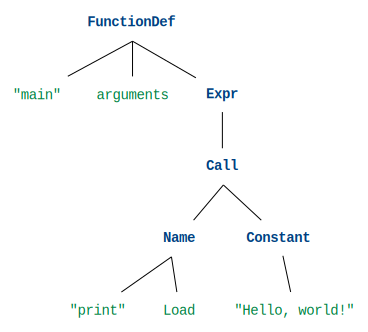

In [23]:
show_ast(main_tree)

We see how the function definition has become a `FunctionDef` node, whose third child is an `Expr` node, which in turn becomes a `Call` – of the `"print"` function with an argument of `"Hello, world!"`.

Each of these AST nodes comes as a _constructor_ – that is, we can invoke `FunctionDef()` to obtain a function definition node, or `Call()` to obtain a call node.
These constructors take the AST _children_ as arguments, but also lots of _optional_ arguments (which we did not use so far). The _dump_ of the AST into a string reveals all the arguments for each constructor:

In [24]:
print(ast.dump(main_tree, indent=4))

Module(
    body=[
        FunctionDef(
            name='main',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Expr(
                    value=Call(
                        func=Name(id='print', ctx=Load()),
                        args=[
                            Constant(value='Hello, world!')],
                        keywords=[]))],
            decorator_list=[])],
    type_ignores=[])


The [Python ast documentation](https://docs.python.org/3/library/ast.html) lists all these constructors, which make up the abstract syntax. There are more than 100 individual constructors! (We said that ASTs are complex, right?)

The nice thing about the above string representation is that we can take it _as is_ and turn it into a tree again:

In [25]:
from ast import *

In [26]:
my_main_tree = Module(
    body=[
        FunctionDef(
            name='main',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Expr(
                    value=Call(
                        func=Name(id='print', ctx=Load()),
                        args=[
                            Constant(value='Hello, world!')],
                        keywords=[]))],
            decorator_list=[])],
    type_ignores=[])

We can take this tree and compile it into executable code:

In [27]:
my_main_tree = fix_missing_locations(my_main_tree)  # required for trees built from constructors
my_main_code = compile(my_main_tree, filename='<unknown>', mode='exec')

In [28]:
del main  # This deletes the definition of main()

In [29]:
exec(my_main_code)  # This defines main() again from `code`

In [30]:
main()

Hello, world!


We can also _unparse_ the tree (= turn it into source code again). (Note how the comment got lost during parsing.)

In [31]:
print(ast.unparse(my_main_tree))

def main():
    print('Hello, world!')


Hence, we can

1. _Parse_ concrete code into ASTs (with `ast.parse()`)
2. _Generate_ new ASTs and _mutate_ existing ones
3. _Unparse_ ASTs to obtain concrete code again (with `ast.unparse()`)

To _generate_ and _mutate_ ASTs (step #2, above), we need means to produce _correct_ ASTs, invoking all constructors with the correct arguments.
The plan is thus to have a _grammar_ for ASTs, which produces (and parses) ASTs as we like.

## A Grammar for ASTs

Programming language grammars are among the most complicated formal grammars around, and ASTs reflect much of this complexity. We will use the [abstract AST grammar](https://docs.python.org/3/library/ast.html) as specified in the Python documentation as base, and build a formal context-free grammar step by step.

### Constants

We will start with simple constants – strings and integers. Again, we use the `fuzzingbook` syntax for grammars, as it allows for easier extension.

In [32]:
import string

In [33]:
ANYTHING_BUT_DOUBLE_QUOTES_AND_BACKSLASH = (string.digits + string.ascii_letters + string.punctuation + ' ').replace('"', '').replace('\\', '')
ANYTHING_BUT_SINGLE_QUOTES_AND_BACKSLASH = (string.digits + string.ascii_letters + string.punctuation + ' ').replace("'", '').replace('\\', '')

In [34]:
ANYTHING_BUT_DOUBLE_QUOTES_AND_BACKSLASH

"0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!#$%&'()*+,-./:;<=>?@[]^_`{|}~ "

In [35]:
ANYTHING_BUT_SINGLE_QUOTES_AND_BACKSLASH

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&()*+,-./:;<=>?@[]^_`{|}~ '

In [36]:
PYTHON_AST_CONSTANTS_GRAMMAR: Grammar = {
    '<start>': [ '<expr>' ],

    # Expressions
    '<expr>': [ '<Constant>', '<Expr>' ],
    '<Expr>': [ 'Expr(value=<expr>)' ],

    # Constants
    '<Constant>': [ 'Constant(value=<literal>)' ],
    '<literal>': [ '<string>', '<integer>', '<float>', '<bool>', '<none>' ],

    # Strings
    '<string>': [ '"<not_double_quotes>*"', "'<not_single_quotes>*'" ],
    '<not_double_quotes>': list(ANYTHING_BUT_DOUBLE_QUOTES_AND_BACKSLASH),
    '<not_single_quotes>': list(ANYTHING_BUT_SINGLE_QUOTES_AND_BACKSLASH),
    # FIXME: The actual rules for Python strings are also more complex:
    # https://docs.python.org/3/reference/lexical_analysis.html#numeric-literals

    # Numbers
    '<integer>': [ '<digit>', '<nonzerodigit><digits>' ],
    '<float>': [ '<integer>.<integer>' ],
    '<nonzerodigit>': ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
    '<digits>': [ '<digit><digits>', '<digit>' ],
    '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    # FIXME: There are _many_ more ways to express numbers in Python; see
    # https://docs.python.org/3/reference/lexical_analysis.html#numeric-literals

    # More
    '<bool>': [ 'True', 'False' ],
    '<none>': [ 'None' ],

    # FIXME: Not supported: bytes, format strings, regex strings...
}

Note that we use _extended Backus-Naur form_ in our grammars (here: `<string>`):

* `<elem>+` stands for one or more instances of `<elem>`;
* `<elem>*` stands for zero or more instances of `<elem>`;
* `<elem>?` stands for one or zero instances of `<elem>`.

A call to `is_valid_grammar()` ensures our grammar is free of common mistakes. Don't write grammars without it!

In [37]:
assert is_valid_grammar(PYTHON_AST_CONSTANTS_GRAMMAR)

In [38]:
constants_grammar = convert_ebnf_grammar(PYTHON_AST_CONSTANTS_GRAMMAR)
constants_solver = ISLaSolver(constants_grammar)
constants_tree_str = str(constants_solver.solve())
print(constants_tree_str)

Expr(value=Constant(value=None))


We can create an AST from this expression and turn it into Python code (well, a literal):

In [39]:
constants_tree = eval(constants_tree_str)
ast.unparse(constants_tree)

'None'

Let's do this a number of times:

In [40]:
def test_samples(grammar: Grammar, iterations: int = 10, start_symbol = None, log: bool = True):
    g = convert_ebnf_grammar(grammar)
    solver = ISLaSolver(g, start_symbol=start_symbol, max_number_free_instantiations=iterations)
    for i in range(iterations):
        tree_str = str(solver.solve())
        tree = eval(tree_str)
        ast.fix_missing_locations(tree)
        if log:
            code = ast.unparse(tree)
            print(f'{code:40} # {tree_str}')

In [41]:
test_samples(PYTHON_AST_CONSTANTS_GRAMMAR)

False                                    # Expr(value=Constant(value=False))
2                                        # Constant(value=2)
None                                     # Constant(value=None)
'#'                                      # Constant(value="#")
550.81                                   # Constant(value=550.81)
True                                     # Constant(value=True)
'.'                                      # Constant(value='.')
467                                      # Constant(value=467)
7894                                     # Constant(value=7894)
263                                      # Constant(value=263)


Our grammar can also _parse_ ASTs obtained from concrete code.

In [42]:
sample_constant_code = "4711"
sample_constant_ast = ast.parse(sample_constant_code).body[0]  # get the `Expr` node
sample_constant_ast_str = ast.dump(sample_constant_ast)
print(sample_constant_ast_str)

Expr(value=Constant(value=4711))


In [43]:
constant_solver = ISLaSolver(constants_grammar)
constant_solver.check(sample_constant_ast_str)

True

Let us now come up with a quiz question: _Does our grammar support negative numbers?_
For this, let's first find out if the `Constant()` constructor also take a _negative_ number as an argument? It turns out it can:

In [44]:
ast.unparse(Constant(value=-1))

'-1'

But what happens if we parse a negative number, say `-1`? One might assume that this simply results in a `Constant(-1)`, right? Try it out yourself!

In [45]:
from bookutils import quiz

In [46]:
quiz("If we parse a negative number, do we obtain ",
    [
        "a `Constant()` with a negative value, or",
        "a unary `-` operator applied to a positive value?"
    ], 1 ** 0 + 1 ** 1)

The answer is that parsing `-1` yields a unary minus `USub()` applied to a positive value:

In [47]:
print(ast.dump(ast.parse('-1')))

Module(body=[Expr(value=UnaryOp(op=USub(), operand=Constant(value=1)))], type_ignores=[])


As unary operators are not part of our grammar (yet), it cannot handle negative numbers:

In [48]:
sample_constant_code = "-1"
sample_constant_ast = ast.parse(sample_constant_code).body[0]  # get the `Expr` node
sample_constant_ast_str = ast.dump(sample_constant_ast)
constant_solver = ISLaSolver(constants_grammar)
constant_solver.check(sample_constant_ast_str)

Error parsing "Expr(value=UnaryOp(op=USub(), operand=Constant(value=1)))" starting with "<start>"


False

In the next sections, we will gradually expand our grammar with more and more Python features, eventually covering (almost) the entire language.

### Excursion: Composites

Let us add composite constants – lists, dictionaries, tuples, etc. Here is how these are represented in an AST:

In [49]:
print(ast.dump(ast.parse("{ 'a': set() }"), indent=4))

Module(
    body=[
        Expr(
            value=Dict(
                keys=[
                    Constant(value='a')],
                values=[
                    Call(
                        func=Name(id='set', ctx=Load()),
                        args=[],
                        keywords=[])]))],
    type_ignores=[])


Let us encode these into a grammar, again using the definitions from the [abstract AST grammar](https://docs.python.org/3/library/ast.html).
All these structures also take _contexts_ in which identifiers are used – `Load()` if they are used for evaluation, `Store()` if they appear on the left-hand side of an assignment (yes, in Python, you can have a tuple on the left-hand side of an assignment, say `(x, y) = (1, 2)`), and `Del()` if they are used as operands in a `del` statement. Right now, we only use `Load()` and `Del()` interchangeably.

In [50]:
PYTHON_AST_COMPOSITES_GRAMMAR: Grammar = extend_grammar(
    PYTHON_AST_CONSTANTS_GRAMMAR, {
    '<expr>': PYTHON_AST_CONSTANTS_GRAMMAR['<expr>'] + [
        '<Dict>', '<Set>', '<List>', '<Tuple>'
    ],

    '<Dict>': [ 'Dict(keys=<expr_list>, values=<expr_list>)' ],
    '<Set>': [ 'Set(elts=<nonempty_expr_list>)', '<EmptySet>' ],
    '<EmptySet>': [ 'Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])' ],
    '<List>': [
        'List(elts=<expr_list>, ctx=Load())',
        'List(elts=<expr_list>, ctx=Del())',
    ],
    '<Tuple>': [
        'Tuple(elts=<expr_list>, ctx=Load())',
        'Tuple(elts=<expr_list>, ctx=Del())',
    ],

    # Lists of expressions
    '<expr_list>': [ '[<exprs>?]' ],
    '<nonempty_expr_list>': [ '[<exprs>]' ],
    '<exprs>': [ '<expr>', '<exprs>, <expr>' ],
})

In [51]:
assert is_valid_grammar(PYTHON_AST_COMPOSITES_GRAMMAR)

In [52]:
for elt in [ '<Constant>', '<Dict>', '<Set>', '<List>', '<Tuple>' ]:
    print(elt)
    test_samples(PYTHON_AST_COMPOSITES_GRAMMAR, start_symbol=elt)
    print()

<Constant>
'c'                                      # Constant(value='c')
96.7                                     # Constant(value=96.7)
None                                     # Constant(value=None)
False                                    # Constant(value=False)
505                                      # Constant(value=505)
'U'                                      # Constant(value="U")
True                                     # Constant(value=True)
41398                                    # Constant(value=41398)
24                                       # Constant(value=24)
72                                       # Constant(value=72)

<Dict>
{}                                       # Dict(keys=[], values=[List(elts=[Dict(keys=[List(elts=[Constant(value=9.63)], ctx=Load())], values=[Tuple(elts=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Set(elts=[Constant(value=True), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])])], ctx=Load())]), Constant(value=2), 

You may encounter a number of uncommon expressions here. For instance:

1. `()` is an empty tuple.
2. `(1,)` is a tuple with one element.
3. `{}` is an empty dictionary; `{1}` is a set with one element.
4. An empty set is denoted by `set()`.

The fact that we use `set()` to represent empty sets is actually a feature of our `PYTHON_AST_COMPOSITES_GRAMMAR` grammar.
If we invoke the `Set()` AST constructor without any elements, we obtain this beautiful expression...

In [53]:
print(ast.unparse(Set(elts=[])))

{*()}


... which indeed evaluates into an empty set.

In [54]:
{*()}

set()

Technically speaking, all of this is correct, but we'd like to stick to (somewhat) more readable code. If you want to confuse your programmer friends, always use `{*()}` instead of `set()`.

### End of Excursion

### Excursion: Expressions

Let us extend our grammar with _expressions_. The Python parser already takes care of precedence rules, so we can treat all unary and binary operators in a similar fashion.

In [55]:
print(ast.dump(ast.parse("2 + 2 is not False"), indent=4))

Module(
    body=[
        Expr(
            value=Compare(
                left=BinOp(
                    left=Constant(value=2),
                    op=Add(),
                    right=Constant(value=2)),
                ops=[
                    IsNot()],
                comparators=[
                    Constant(value=False)]))],
    type_ignores=[])


In [56]:
PYTHON_AST_EXPRS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_COMPOSITES_GRAMMAR, {
    '<expr>': PYTHON_AST_COMPOSITES_GRAMMAR['<expr>'] + [
        '<BoolOp>', '<BinOp>', '<UnaryOp>', '<Compare>',
    ],

    # Booleans: and or
    '<BoolOp>': [ 'BoolOp(op=<boolop>, values=<expr_list>)' ],
    '<boolop>': [ 'And()', 'Or()' ],

    # Binary operators: + - * ...
    '<BinOp>': [ 'BinOp(left=<expr>, op=<operator>, right=<expr>)' ],
    '<operator>': [ 'Add()', 'Sub()', 'Mult()', 'MatMult()',
                   'Div()', 'Mod()', 'Pow()',
                   'LShift()', 'RShift()', 'BitOr()', 'BitXor()', 'BitAnd()',
                   'FloorDiv()' ],

    # Unary operators: not + - ...
    '<UnaryOp>': [ 'UnaryOp(op=<unaryop>, operand=<expr>)'],
    '<unaryop>': [ 'Invert()', 'Not()', 'UAdd()', 'USub()' ],

    # Comparisons: == != < <= > >= is in ...
    '<Compare>': [ 'Compare(left=<expr>, ops=<cmpop_list>, comparators=<expr_list>)'],
    '<cmpop_list>': [ '[<cmpops>?]' ],
    '<cmpops>': [ '<cmpop>', '<cmpop>, <cmpops>' ],
    '<cmpop>': [ 'Eq()', 'NotEq()', 'Lt()', 'LtE()', 'Gt()', 'GtE()',
                 'Is()', 'IsNot()', 'In()', 'NotIn()' ],

    # FIXME: There's a few more expressions: GeneratorExp, Await, YieldFrom, ...
})

In [57]:
assert is_valid_grammar(PYTHON_AST_EXPRS_GRAMMAR)

In [58]:
for elt in [ '<BoolOp>', '<BinOp>', '<UnaryOp>', '<Compare>' ]:
    print(elt)
    test_samples(PYTHON_AST_EXPRS_GRAMMAR, start_symbol=elt)
    print()

<BoolOp>
() and {-([]) / (set(), set()), {
True: set()}} # BoolOp(op=And(), values=[BoolOp(op=Or(), values=[]), Set(elts=[BinOp(left=UnaryOp(op=USub(), operand=Compare(left=List(elts=[], ctx=Del()), ops=[], comparators=[])), op=Div(), right=Tuple(elts=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])], ctx=Load())), Dict(keys=[Expr(value=Constant(value=True))], values=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), List(elts=[], ctx=Load())])])])
(set(), set(), set() @ set() | set() + set()) and set() ** (set() ^ set()) * set() # BoolOp(op=And(), values=[Tuple(elts=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), BinOp(left=BinOp(left=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), op=MatMult(), 

Not all of these expressions are _type-correct_. For instance, `set() * set()` raises a type error at runtime. They _can_ be properly parsed, though.

How good is our grammar at this point? Let us create 20 expressions and check how many of these
1. parse without `SyntaxError`
2. evaluate without `TypeError`.

In [59]:
expr_iterations = 20
bad_syntax = 0
bad_type = 0
ast_exprs_grammar = convert_ebnf_grammar(PYTHON_AST_EXPRS_GRAMMAR)
expr_solver = ISLaSolver(ast_exprs_grammar, max_number_free_instantiations=expr_iterations)
for i in range(expr_iterations):
    expr_tree = eval(str(expr_solver.solve()))
    expr_tree = fix_missing_locations(expr_tree)
    expr_str = ast.unparse(expr_tree)
    print(i, expr_str)
    try:
        ...  # insert parsing code here
    except SyntaxError:
        bad_syntax += 1
    except TypeError:
        bad_type += 1

    try:
        ...  # <-- insert evaluation code here
    except TypeError:
        bad_type += 1
    except SyntaxError:
        bad_syntax += 1

print(f"Bad syntax: {bad_syntax}/{expr_iterations}")
print(f"Bad type: {bad_type}/{expr_iterations}")

0 set()
1 
2 [
~(False,) >> {635: (set() @ set() & set(),), 99.1 not in set() ** set(): {[set() ^ set()]}}]
3 (set() * set() - (set() + set())) / ((set() ^ set()) % set() | set() << set() % set())
4 not None
5 -+(True and '#' and 'x')
6 (8876 > 46 in 36 != 50)
7 24
8 "LfDW-kSM|tpB&+V*RgQ7U]3xq)zh~n^`wTdie5jvPN: A2K?$ZGJ(X;%@sr9mcIu!}OC/1><b=y'0H8o_.4lFYa{6[,>E?"
9 'o,awXihgeM[581Bln"RA60^k2N_L=d$C`7U~f)(&ZG]#m+DqF|PjpIQ<.4ur@ T!-W}Vs:Y{*zOEJb3StHK>?y%c/;iv9'
10 ((set()) < set() is set()) >= ((set()))
11 ((set())) == ((set()) <= set())
12 
13 
14 set()
15 set()
16 []
17 
18 ((() or 'k5'))
19 () | []
Bad syntax: 0/20
Bad type: 0/20


We're not doing too bad here.
It is possible, in principle, to use ISLa constraints such that the resulting code will be properly typed - but this would take hundreds to thousands of rules. We will leave this exercise to the reader.

Note that you should _not_ repeat this experiment once _identifiers_ come into play. There is a remote chance that the fuzzer synthesizes a call like `os.remove("/")` – and away goes your file system!

### End of Excursion

### Excursion: Names and Function Calls


Let us add some _identifiers_ such that we can call _functions_.

In [60]:
ID_START = string.ascii_letters + '_'
ID_CONTINUE = ID_START + string.digits

In [61]:
ID_CONTINUE

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_0123456789'

In [62]:
print(ast.dump(ast.parse("xyzzy(a, b=c)"), indent=4))

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='xyzzy', ctx=Load()),
                args=[
                    Name(id='a', ctx=Load())],
                keywords=[
                    keyword(
                        arg='b',
                        value=Name(id='c', ctx=Load()))]))],
    type_ignores=[])


In [63]:
PYTHON_AST_IDS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_EXPRS_GRAMMAR, {
    '<expr>': PYTHON_AST_EXPRS_GRAMMAR['<expr>'] + [
        '<Name>', '<Call>'
    ],

    # Identifiers
    '<Name>': [
        'Name(id=<identifier>, ctx=Load())',
        'Name(id=<identifier>, ctx=Del())'
    ],
    '<identifier>': [ "'<id>'" ],
    '<id>': [ '<id_start><id_continue>*' ],
    '<id_start>': list(ID_START),
    '<id_continue>': list(ID_CONTINUE),
    # FIXME: Actual rules are a bit more complex; see
    # https://docs.python.org/3/reference/lexical_analysis.html#identifiers

    # Function Calls
   '<Call>': [ 'Call(func=<func>, args=<expr_list>, keywords=<keyword_list>)' ],
   '<func>': [ '<expr>' ],  # Actually <Expr>, but this is more readable and parses 90%
    '<keyword_list>': [ '[<keywords>?]' ],
    '<keywords>': [ '<keyword>', '<keyword>, <keywords>' ],
    '<keyword>': [ 'keyword(arg=<identifier>, value=<expr>)' ]
})

In [64]:
assert is_valid_grammar(PYTHON_AST_IDS_GRAMMAR)

In [65]:
for elt in [ '<Name>', '<Call>' ]:
    print(elt)
    test_samples(PYTHON_AST_IDS_GRAMMAR, start_symbol=elt)
    print()

<Name>
n                                        # Name(id='n', ctx=Load())
vmGtKyT3Oq1gBC_srAIRaeQw6Dh8V5oLdj9FcvHfb4MpPZiNuEJ27WYU0lnkSxX9Lz # Name(id='vmGtKyT3Oq1gBC_srAIRaeQw6Dh8V5oLdj9FcvHfb4MpPZiNuEJ27WYU0lnkSxX9Lz', ctx=Del())
h                                        # Name(id='h', ctx=Load())
L                                        # Name(id='L', ctx=Del())
M                                        # Name(id='M', ctx=Load())
g                                        # Name(id='g', ctx=Del())
P                                        # Name(id='P', ctx=Del())
It                                       # Name(id='It', ctx=Del())
jGn7g                                    # Name(id='jGn7g', ctx=Load())
psj                                      # Name(id='psj', ctx=Del())

<Call>
{{}()}(set(), set(), W=set(), a=set())   # Call(func=Set(elts=[Call(func=Dict(keys=[], values=[]), args=[], keywords=[])]), args=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Compare(left=Call(func

In [66]:
ast_ids_grammar = convert_ebnf_grammar(PYTHON_AST_IDS_GRAMMAR)

In [67]:
id_solver = ISLaSolver(ast_ids_grammar, start_symbol='<id>')
assert id_solver.check('open')

In [68]:
name_solver = ISLaSolver(ast_ids_grammar)
assert name_solver.check("Name(id='open', ctx=Load())")

In [69]:
call_solver = ISLaSolver(ast_ids_grammar, start_symbol='<keyword_list>')
assert call_solver.check('[]')

In [70]:
call_str = ast.dump(ast.parse('open()').body[0].value)  # type: ignore
call_solver = ISLaSolver(ast_ids_grammar)
assert call_solver.check(call_str)

### End of Excursion

### Excursion: Attributes and Subscripts


Let us add attributes and subscripts.

In [71]:
print(ast.dump(ast.parse("a[b].c"), indent=4))

Module(
    body=[
        Expr(
            value=Attribute(
                value=Subscript(
                    value=Name(id='a', ctx=Load()),
                    slice=Name(id='b', ctx=Load()),
                    ctx=Load()),
                attr='c',
                ctx=Load()))],
    type_ignores=[])


In [72]:
PYTHON_AST_ATTRS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_IDS_GRAMMAR, {
    '<expr>': PYTHON_AST_IDS_GRAMMAR['<expr>'] + [
        '<Attribute>', '<Subscript>', '<Starred>',
    ],

    # Attributes
    '<Attribute>': [
        'Attribute(value=<expr>, attr=<identifier>, ctx=Load())',
        'Attribute(value=<expr>, attr=<identifier>, ctx=Del())',
    ],

    # Subscripts
    '<Subscript>': [
        'Subscript(value=<expr>, slice=<Slice>, ctx=Load())',
        'Subscript(value=<expr>, slice=<Slice>, ctx=Del())',
    ],
    '<Slice>': [
        'Slice()',
        'Slice(<expr>)',
        'Slice(<expr>, <expr>)',
        'Slice(<expr>, <expr>, <expr>)',
    ],

    # Starred
    '<Starred>': [
        'Starred(value=<expr>, ctx=Load())',
        'Starred(value=<expr>, ctx=Del())',
    ],

    # We're extending the set of callers a bit
    '<func>': [ '<Name>', '<Attribute>', '<Subscript>' ],
})

In [73]:
assert is_valid_grammar(PYTHON_AST_ATTRS_GRAMMAR)

In [74]:
for elt in [ '<Attribute>', '<Subscript>', '<Starred>' ]:
    print(elt)
    test_samples(PYTHON_AST_ATTRS_GRAMMAR, start_symbol=elt)
    print()

<Attribute>
(set()).sB                               # Attribute(value=Compare(left=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), ops=[Is()], comparators=[]), attr='sB', ctx=Del())
FREed3NqLMUugcArznkP9yhK2D1bfmsCoD0.aQHvYZ_VatlOGFxjS87ipTw0WJ6XI45C1 # Attribute(value=Name(id='FREed3NqLMUugcArznkP9yhK2D1bfmsCoD0', ctx=Del()), attr='aQHvYZ_VatlOGFxjS87ipTw0WJ6XI45C1', ctx=Load())
*True .V[() % {}:(set(), set(), set()):[set()[:](), ~set()]].Z0rA # Attribute(value=Expr(value=Starred(value=Subscript(value=Attribute(value=Constant(value=True), attr='V', ctx=Load()), slice=Slice(BinOp(left=BoolOp(op=And(), values=[]), op=Mod(), right=Dict(keys=[], values=[])), Tuple(elts=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])], ctx=Load()), List(elts=[Call(func=Subscript(value=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), slice=Slice(), 

### End of Excursion

### Excursion: Variable Assignments


Now for variable assignments. These make things more complex, as we have a restricted set of expressions on the left hand side of an assignment.

In [75]:
PYTHON_AST_ASSIGNMENTS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_ATTRS_GRAMMAR, {
    '<start>': [ '<stmt>' ],

    '<stmt>': [
        '<Assign>', '<AugAssign>',
        '<Expr>'
    ],

    # Assignments
    '<Assign>': [
        'Assign(targets=<nonempty_lhs_expr_list>, value=<expr><type_comment>?)',
    ],
    '<type_comment>': [ ', type_comment=<string>' ],
    '<AugAssign>': [
        'AugAssign(target=<lhs_expr>, op=<operator>, value=<expr>)',
    ],

    # Lists of left-hand side expressions
    # '<lhs_expr_list>': [ '[<lhs_exprs>?]' ],
    '<nonempty_lhs_expr_list>': [ '[<lhs_exprs>]' ],
    '<lhs_exprs>': [ '<lhs_expr>', '<lhs_exprs>, <lhs_expr>' ],

    # On the left-hand side of assignments, we allow a number of structures
    '<lhs_expr>': [
        '<lhs_Name>',  # Most common
        '<lhs_List>', '<lhs_Tuple>',
        '<lhs_Attribute>',
        '<lhs_Subscript>',
        '<lhs_Starred>',
    ],

    '<lhs_Name>': [ 'Name(id=<identifier>, ctx=Store())', ],

    '<lhs_List>': [
        'List(elts=<nonempty_lhs_expr_list>, ctx=Store())',
    ],
    '<lhs_Tuple>': [
        'Tuple(elts=<nonempty_lhs_expr_list>, ctx=Store())',
    ],
    '<lhs_Attribute>': [
        'Attribute(value=<lhs_expr>, attr=<identifier>, ctx=Store())',
    ],
    '<lhs_Subscript>': [
        'Subscript(value=<lhs_expr>, slice=<Slice>, ctx=Store())',
    ],
    '<lhs_Starred>': [
        'Starred(value=<lhs_expr>, ctx=Store())',
    ],
})

In [76]:
assert is_valid_grammar(PYTHON_AST_ASSIGNMENTS_GRAMMAR)

In [77]:
for elt in ['<Assign>', '<AugAssign>']:
    print(elt)
    test_samples(PYTHON_AST_ASSIGNMENTS_GRAMMAR, start_symbol=elt)
    print()

<Assign>
([U, S, z[:][:]], *o.FQA) = I = (3,)[:]  # Assign(targets=[Tuple(elts=[List(elts=[Name(id='U', ctx=Store()), Name(id='S', ctx=Store()), Subscript(value=Subscript(value=Name(id='z', ctx=Store()), slice=Slice(), ctx=Store()), slice=Slice(), ctx=Store())], ctx=Store()), Attribute(value=Starred(value=Name(id='o', ctx=Store()), ctx=Store()), attr='FQA', ctx=Store())], ctx=Store()), Name(id='I', ctx=Store())], value=Subscript(value=Tuple(elts=[Constant(value=3)], ctx=Del()), slice=Slice(), ctx=Del()))
b[set():] = L[:] = i[:][{}:set()] = *
.q0DVnL # type: K # Assign(targets=[Subscript(value=Name(id='b', ctx=Store()), slice=Slice(Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])), ctx=Store()), Subscript(value=Name(id='L', ctx=Store()), slice=Slice(), ctx=Store()), Subscript(value=Subscript(value=Name(id='i', ctx=Store()), slice=Slice(), ctx=Store()), slice=Slice(Dict(keys=[], values=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])), ctx=Store())], value=Star

### End of Excursion

### Excursion: Statements


Now for statements. There's quite a lot of these.

In [78]:
PYTHON_AST_STMTS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_ASSIGNMENTS_GRAMMAR, {
    '<start>': [ '<stmt>' ],

    '<stmt>': PYTHON_AST_ASSIGNMENTS_GRAMMAR['<stmt>'] + [
        '<For>', '<While>', '<If>',
        '<Return>', '<Delete>', '<Assert>',
        '<Pass>', '<Break>', '<Continue>',
        '<With>'
    ],

    # Control structures
    '<For>': [
        'For(target=<lhs_expr>, iter=<expr>, body=<nonempty_stmt_list>, orelse=<stmt_list><type_comment>)'
    ],
    '<stmt_list>': [ '[<stmts>?]' ],
    '<nonempty_stmt_list>': [ '[<stmts>]' ],
    '<stmts>': [ '<stmt>', '<stmt>, <stmts>' ],

    '<While>': [
        'While(test=<expr>, body=<nonempty_stmt_list>, orelse=<stmt_list>)'
    ],

    '<If>': [
        'If(test=<expr>, body=<nonempty_stmt_list>, orelse=<stmt_list>)'
    ],

    '<With>': [
        'With(items=<withitem_list>, body=<nonempty_stmt_list><type_comment>?)'
    ],
    '<withitem_list>': [ '[<withitems>?]' ],
    '<withitems>': [ '<withitem>', '<withitems>, <withitem>' ],
    '<withitem>': [
        'withitem(context_expr=<expr>)',
        'withitem(context_expr=<expr>, optional_vars=<lhs_expr>)',
    ],

    # Other statements
    '<Return>': [
        'Return()',
        'Return(value=<expr>)'
    ],
    '<Delete>': [
        'Delete(targets=<expr_list>)'
    ],
    '<Assert>': [
        'Assert(test=<expr>)',
        'Assert(test=<expr>, msg=<expr>)'
    ],
    '<Pass>': [ 'Pass()'],
    '<Break>': [ 'Break()' ],
    '<Continue>': [ 'Continue()']

    # FIXME: A few more: AsyncFor, AsyncWith, Match, Try, TryStar, With
    # Import, ImportFrom, Global, Nonlocal...
})

In [79]:
assert is_valid_grammar(PYTHON_AST_STMTS_GRAMMAR)

In [80]:
for elt in PYTHON_AST_STMTS_GRAMMAR['<stmt>']:
    print(elt)
    test_samples(PYTHON_AST_STMTS_GRAMMAR, start_symbol=elt)
    print()

<Assign>
[V, L][:].pzMx7 = {}                     # Assign(targets=[Attribute(value=Subscript(value=List(elts=[Name(id='V', ctx=Store()), Name(id='L', ctx=Store())], ctx=Store()), slice=Slice(), ctx=Store()), attr='pzMx7', ctx=Store())], value=Dict(keys=[], values=[Attribute(value=Compare(left=Name(id='QnD', ctx=Del()), ops=[Is()], comparators=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])]), attr='J', ctx=Del())]))
*X[:] = (I[:], _, x) = ()[set():set():set()](set(), set()) # type: ] # Assign(targets=[Starred(value=Subscript(value=Name(id='X', ctx=Store()), slice=Slice(), ctx=Store()), ctx=Store()), Tuple(elts=[Subscript(value=Name(id='I', ctx=Store()), slice=Slice(), ctx=Store()), Name(id='_', ctx=Store()), Name(id='x', ctx=Store())], ctx=Store())], value=Call(func=Subscript(value=Tuple(elts=[], ctx=Del()), slice=Slice(Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), Call(func=Name(id="set", ctx=Loa

Let us see if we can also _parse_ code properly. Here is a sample:

In [81]:
with_tree = ast.parse("""
with open('foo.txt') as myfile:
    content = myfile.readlines()
    if content is not None:
        print(content)
""")

In [82]:
python_ast_stmts_grammar = convert_ebnf_grammar(PYTHON_AST_STMTS_GRAMMAR)
with_tree_str = ast.dump(with_tree.body[0])  # get the `With(...)` subtree
with_solver = ISLaSolver(python_ast_stmts_grammar)
assert with_solver.check(with_tree_str)

It seems our grammar can also parse non-trivial code properly. We are doing well!

### End of Excursion

### Excursion: Function Definitions

Now for function definitions.
Not too many surprises here.

In [83]:
print(ast.dump(ast.parse("""
def f(a, b=1):
    pass
"""
), indent=4))

Module(
    body=[
        FunctionDef(
            name='f',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='a'),
                    arg(arg='b')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[
                    Constant(value=1)]),
            body=[
                Pass()],
            decorator_list=[])],
    type_ignores=[])


In [84]:
PYTHON_AST_DEFS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_STMTS_GRAMMAR, {
    '<stmt>': PYTHON_AST_STMTS_GRAMMAR['<stmt>'] + [ '<FunctionDef>' ],

    '<FunctionDef>': [
        'FunctionDef(name=<identifier>, args=<arguments>, body=<nonempty_stmt_list>, decorator_list=<expr_list><returns>?<type_comment>?)'
    ],
    '<arguments>': [
        'arguments(posonlyargs=<arg_list>, args=<arg_list><vararg>?, kwonlyargs=<arg_list>, kw_defaults=<expr_list><kwarg>?, defaults=<expr_list>)'
    ],

    '<arg_list>': [ '[<args>?]' ],
    '<args>': [ '<arg>', '<arg>, <arg>' ],
    '<arg>': [ 'arg(arg=<identifier>)' ],

    '<vararg>': [ ', vararg=<arg>' ],
    '<kwarg>': [ ', kwarg=<arg>' ],
    '<returns>': [ ', returns=<expr>' ],

    # FIXME: Not handled: AsyncFunctionDef, ClassDef
})

In Python 3.12 and later, function definitions also have a `type_param` field:

In [85]:
import sys

In [86]:
# do import this unconditionally
if sys.version_info >= (3, 12):
    PYTHON_AST_DEFS_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_DEFS_GRAMMAR, {
    '<FunctionDef>': [
        'FunctionDef(name=<identifier>, args=<arguments>, body=<nonempty_stmt_list>, decorator_list=<expr_list><returns>?<type_comment>?<type_params>?)'
    ],
    '<type_params>': [
        ', type_params=<type_param_list>',
    ],
    '<type_param_list>': [ '[<type_param>?]' ],
    '<type_param>': [ '<TypeVar>', '<ParamSpec>', '<TypeVarTuple>' ],
    '<TypeVar>': [
        'TypeVar(name=<identifier>(, bound=<expr>)?)'
    ],
    '<ParamSpec>': [
        'ParamSpec(name=<identifier>)'
    ],
    '<TypeVarTuple>': [
        'TypeVarTuple(name=<identifier>)'
    ]
    })

In [87]:
assert is_valid_grammar(PYTHON_AST_DEFS_GRAMMAR)

In [88]:
for elt in [ '<arguments>', '<FunctionDef>' ]:
    print(elt)
    test_samples(PYTHON_AST_DEFS_GRAMMAR, start_symbol=elt)
    print()

<arguments>
f, /, xXK31GmhN, dCoZpr                  # arguments(posonlyargs=[arg(arg='f')], args=[arg(arg='xXK31GmhN'), arg(arg='dCoZpr')], kwonlyargs=[], kw_defaults=[BinOp(left=Name(id='P4PQ97yLj', ctx=Del()), op=Mod(), right=Starred(value=BoolOp(op=And(), values=[Subscript(value=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), slice=Slice(), ctx=Del()), Constant(value=True)]), ctx=Load()))], defaults=[])
M, /, *L, b=set(), **ccU                 # arguments(posonlyargs=[arg(arg='M')], args=[], vararg=arg(arg='L'), kwonlyargs=[arg(arg='b'), arg(arg='D')], kw_defaults=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])], kwarg=arg(arg='ccU'), defaults=[])
O, p, /, N, R, *l, **F                   # arguments(posonlyargs=[arg(arg='O'), arg(arg='p')], args=[arg(arg='N'), arg(arg='R')], vararg=arg(arg='l'), kwonlyargs=[arg(arg='S')], kw_defaults=[], kwarg=arg(arg='F'), defaults=[])
W, i=(), /, n={}, *B, I=[set().H], **T   # arguments(posonlyargs=[arg(arg='W'), arg(arg

### End of Excursion

### Excursion: Modules

We close with _modules_ – sequences of definitions.
After all the other definitions, this is now fairly straightforward.

In [89]:
PYTHON_AST_MODULE_GRAMMAR: Grammar = extend_grammar(PYTHON_AST_DEFS_GRAMMAR, {
    '<start>': [ '<mod>' ],
    '<mod>': [ '<Module>' ],
    '<Module>': [ 'Module(body=<nonempty_stmt_list>, type_ignores=<type_ignore_list>)'],

    '<type_ignore_list>': [ '[<type_ignores>?]' ],
    '<type_ignores>': [ '<type_ignore>', '<type_ignore>, <type_ignore>' ],
    '<type_ignore>': [ 'TypeIgnore(lineno=<integer>, tag=<string>)' ],
})

In [90]:
assert is_valid_grammar(PYTHON_AST_MODULE_GRAMMAR)

In [91]:
for elt in [ '<Module>' ]:
    print(elt)
    test_samples(PYTHON_AST_MODULE_GRAMMAR, start_symbol=elt)
    print()

<Module>
pass                                     # Module(body=[Pass()], type_ignores=[TypeIgnore(lineno=427, tag="5"), TypeIgnore(lineno=5, tag='M')])
for H in {}: # type: ,
    return
with set(): # type: .
    continue # Module(body=[For(target=Name(id='H', ctx=Store()), iter=Dict(keys=[], values=[]), body=[Return()], orelse=[], type_comment=','), With(items=[withitem(context_expr=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]))], body=[Continue()], type_comment=".")], type_ignores=[])
assert (set()[:](), p).u4UqXZs1[:]       # Module(body=[Assert(test=Subscript(value=Attribute(value=Tuple(elts=[Call(func=Subscript(value=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), slice=Slice(), ctx=Del()), args=[], keywords=[]), Name(id='p', ctx=Load())], ctx=Load()), attr='u4UqXZs1', ctx=Load()), slice=Slice(), ctx=Load()))], type_ignores=[TypeIgnore(lineno=348, tag='>. #sju8dCaHzS/')])
if [set()]:
    K = set()
else:
    del  # Module(body=[If(test=List(elts=[Call(fun

### End of Excursion

At this point, we have covered (almost) all AST elements of Python.
There would be a few more Python elements to consider (marked as `FIXME`, above), but we'll leave these to the reader.
Let us define `PYTHON_AST_GRAMMAR` as the official grammar coming out of this chapter.

In [92]:
PYTHON_AST_GRAMMAR = PYTHON_AST_MODULE_GRAMMAR
python_ast_grammar = convert_ebnf_grammar(PYTHON_AST_GRAMMAR)

Here are a few (very weird) examples of Python functions we can produce.
All of these are valid, but only _syntactically_ – very few of the code samples produced this way will actually result in something meaningful.

In [93]:
for elt in [ '<FunctionDef>' ]:
    print(elt)
    test_samples(PYTHON_AST_GRAMMAR, start_symbol=elt)
    print()

<FunctionDef>
def T(): # type: 
    break              # FunctionDef(name='T', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Break()], decorator_list=[], type_comment='')
@set()
def zv() -> ():
    pass          # FunctionDef(name='zv', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Pass()], decorator_list=[Call(func=Name(id="set", ctx=Load()), args=[], keywords=[])], returns=Tuple(elts=[], ctx=Del()))
def j():
    continue                    # FunctionDef(name='j', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Continue()], decorator_list=[])
def L():
    return                      # FunctionDef(name='L', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Return()], decorator_list=[])
@set()
def A() -> set(): # type: 
    return
    return # FunctionDef(name='A', args=arguments(posonlyargs=[], args=[], kwonlyargs=

## A Class for Fuzzing Python

For convenience, let us introduce a class `PythonFuzzer` that makes use of the above grammar in order to produce Python code. This will be fairly easy to use.

In [94]:
class PythonFuzzer(ISLaSolver):
    """Produce Python code."""

    def __init__(self,
                 start_symbol: Optional[str] = None, *,
                 grammar: Optional[Grammar] = None,
                 constraint: Optional[str] =None,
                 **kw_params) -> None:
        """Produce Python code. Parameters are:

        * `start_symbol`: The grammatical entity to be generated (default: `<FunctionDef>`)
        * `grammar`: The EBNF grammar to be used (default: `PYTHON__AST_GRAMMAR`); and
        * `constraint` an ISLa constraint (if any).

        Additional keyword parameters are passed to the `ISLaSolver` superclass.
        """
        if start_symbol is None:
            start_symbol = '<FunctionDef>'
        if grammar is None:
            grammar = PYTHON_AST_GRAMMAR
        assert start_symbol in grammar

        g = convert_ebnf_grammar(grammar)
        if constraint is None:
            super().__init__(g, start_symbol=start_symbol, **kw_params)
        else:
            super().__init__(g, constraint, start_symbol=start_symbol, **kw_params)

    def fuzz(self) -> str:
        """Produce a Python code string."""
        abstract_syntax_tree = eval(str(self.solve()))
        ast.fix_missing_locations(abstract_syntax_tree)
        return ast.unparse(abstract_syntax_tree)

By default, the `PythonFuzzer` will produce a _function definition_ - that is, a function header and body.

In [95]:
fuzzer = PythonFuzzer()
print(fuzzer.fuzz())

def b(): # type: 
    return


By passing a start symbol as parameter, you can have `PythonFuzzer` produce arbitrary Python elements:

In [96]:
fuzzer = PythonFuzzer('<While>')
print(fuzzer.fuzz())

while o():
    pass
else:
    continue
    for [m, f[:]] in [*set(), +set()]: # type: 
        set()
        with :
            return
        break


Here is a list of all possible start symbols:

In [97]:
sorted(list(PYTHON_AST_GRAMMAR.keys()))

['<Assert>',
 '<Assign>',
 '<Attribute>',
 '<AugAssign>',
 '<BinOp>',
 '<BoolOp>',
 '<Break>',
 '<Call>',
 '<Compare>',
 '<Constant>',
 '<Continue>',
 '<Delete>',
 '<Dict>',
 '<EmptySet>',
 '<Expr>',
 '<For>',
 '<FunctionDef>',
 '<If>',
 '<List>',
 '<Module>',
 '<Name>',
 '<Pass>',
 '<Return>',
 '<Set>',
 '<Slice>',
 '<Starred>',
 '<Subscript>',
 '<Tuple>',
 '<UnaryOp>',
 '<While>',
 '<With>',
 '<arg>',
 '<arg_list>',
 '<args>',
 '<arguments>',
 '<bool>',
 '<boolop>',
 '<cmpop>',
 '<cmpop_list>',
 '<cmpops>',
 '<digit>',
 '<digits>',
 '<expr>',
 '<expr_list>',
 '<exprs>',
 '<float>',
 '<func>',
 '<id>',
 '<id_continue>',
 '<id_start>',
 '<identifier>',
 '<integer>',
 '<keyword>',
 '<keyword_list>',
 '<keywords>',
 '<kwarg>',
 '<lhs_Attribute>',
 '<lhs_List>',
 '<lhs_Name>',
 '<lhs_Starred>',
 '<lhs_Subscript>',
 '<lhs_Tuple>',
 '<lhs_expr>',
 '<lhs_exprs>',
 '<literal>',
 '<mod>',
 '<none>',
 '<nonempty_expr_list>',
 '<nonempty_lhs_expr_list>',
 '<nonempty_stmt_list>',
 '<nonzerodigit>

## Customizing the Python Fuzzer

When fuzzing, you may be interested in _specific_ properties of the produced output. How can we influence the code that `PythonFuzzer` produces? We explore two ways:

* By adjusting the _grammar_ to our needs
* By adding _constraints_ that customize the output for us.

### Adjusting the Grammar

A simple way to adjust output generation is to _adapt the grammar_.


Let us assume you'd like to have function definitions without decorators.
To achieve this, you can _alter the rule that produces function definitions_:

In [98]:
PYTHON_AST_GRAMMAR['<FunctionDef>']

['FunctionDef(name=<identifier>, args=<arguments>, body=<nonempty_stmt_list>, decorator_list=<expr_list><returns>?<type_comment>?)']

As any AST rule, it comes in _abstract syntax_, so we first have to identify the element we'd like to adjust.
In our case, this is `decorator_list`.

Since decorator_list is a list, we can alter the rule to produce empty lists only.
To create a new adapted grammar, we do not alter the existing `PYTHON_AST_GRAMMAR`.
Instead, we use the `extend_grammar()` function to create a new grammar with a new, adapted rule for `<FunctionDef>`:

In [99]:
python_ast_grammar_without_decorators: Grammar = extend_grammar(PYTHON_AST_GRAMMAR,
{
    '<FunctionDef>' :
        ['FunctionDef(name=<identifier>, args=<arguments>, body=<nonempty_stmt_list>, decorator_list=[])']
})

However, we're not done yet.
We also need to ensure that our grammar is _valid_, as any misspelled nonterminal identifier will result in problems during production.
For this, we use the `is_valid_grammar()` function:

In [100]:
from ExpectError import ExpectError

In [101]:
with ExpectError():
    assert is_valid_grammar(python_ast_grammar_without_decorators)

'<returns>': defined, but not used. Consider applying trim_grammar() on the grammar
'<returns>': unreachable from <start>. Consider applying trim_grammar() on the grammar
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_4461/3611578183.py", line 2, in <cell line: 1>
    assert is_valid_grammar(python_ast_grammar_without_decorators)
AssertionError (expected)


We see that with our change, our grammar has an _orphaned rule_: The `<returns>` rule is no longer used.
This is because `<returns>` is part of the `<type_annotation>` we just have deleted.
(`<type_annotation>` is still used when defining types for variables.)

To fix this, we need to delete the `<returns>` rule from our grammar.
Fortunately, we have a function `trim_grammar()`, which deletes all orphaned rules:

In [102]:
python_ast_grammar_without_decorators = trim_grammar(python_ast_grammar_without_decorators)

With this, our grammar becomes valid...

In [103]:
assert is_valid_grammar(python_ast_grammar_without_decorators)

... and we can use it for fuzzing - now without decorators:

In [104]:
fuzzer = PythonFuzzer(grammar=python_ast_grammar_without_decorators)
print(fuzzer.fuzz())

def A():
    return
    continue


Adjusting the grammar is straightforward once you understood the grammar structure, but the AST grammar is complex; also, your changes and extensions tie you closely to the grammar structure.
Carefully study how the individual rules are defined, above.

### Using Constraints for Customizing

A more elegant alternative to altering the grammar is to make use of _constraints_ that tune the grammar to your needs.
Since `PythonFuzzer` is derived from `ISLaSolver`, we can pass a `constraint` argument constraining the grammar, as discussed in the chapter on [fuzzing with constraints](FuzzingWithConstraints.ipynb).



If we want to have a function definition with 10 characters in each identifier, we make use of an ISLa constraint:

In [105]:
fuzzer = PythonFuzzer(constraint='str.len(<id>) = 10')
print(fuzzer.fuzz())

def ADJ4l5Tlq_():
    return


We can also constrain individual children – say, the actual identifier of the function.

In [106]:
# Also works (the <identifier> has quotes)
fuzzer = PythonFuzzer(constraint='<FunctionDef>.<identifier> = "\'my_favorite_function\'"')
print(fuzzer.fuzz())

@'K'
def my_favorite_function(I, /, *, Dq={set(): set(), set(): set()}, **Q) -> ([][():] in set() >= O) // (*[q6[*set():()]],):
    return (not ai.w(set() or set())).voetXABV


Assume we want to test how the compiler handles large numbers. Let us define a constraint such that the function body (`<nonempty_stmt_list>`) contains at least one integer (`<integer>`) with a value of at least 1000:

In [107]:
fuzzer = PythonFuzzer(constraint=
"""
    exists <integer> x:
        (inside(x, <nonempty_stmt_list>) and str.to.int(x) > 1000)
""")
print(fuzzer.fuzz())

@{}
@
{set()[:]}
@R(() - set())
def Fz(yw, l=~(), /, *, **rhnC) -> [Ep4vmVd3RqNGD1s87UXjKgLH9VY].u0Pl6bOkaorfZeucYIyiE2SQ5TAtW_MBFJx: # type: 
    del 1008


Assume we'd like to test compilers with non-trivial functions. Here's how to define a constraint such that the function body has exactly _three_ statements (`<stmt>`). Note that this can take more than a minute to resolve, but the result definitely is a nontrivial function.

In [108]:
# This will not work with ISLa 2
fuzzer = PythonFuzzer(constraint="""
    forall <FunctionDef> def: count(def, "<stmt>", "3")
""")
print(fuzzer.fuzz())

@[{(*RkVG[(set(), set(), set()):]): 'F'}]
def Qg(_, *dd, V=set() | A, **H) -> (set() // set() ^ set() @ set() & set()) >> (set() - set()) ** (set() / set()): # type: Q-(U'@<*=j4`tH1R%u&L53ImK~Z/8$NEWr!l].o,_Xgf?#JvM d)PTGk[b07a}C>yVzS^A2qDnB|+;sw:eO{ixYc6h9mpA4:&
    with *
    set().z.DS0(set(), set(), (), l=set()[:]): # type: k
        return
    pass


And finally, if we want the decorator list to be empty, as in our grammar-altering example, we can constrain the decorator list to be empty:

In [109]:
# ignore
# with ExpectError(mute=True):
#     # Triggers an ISLa error (AssertionError)
#     fuzzer = PythonFuzzer(constraint='''
#         str.contains(<FunctionDef>, "decorator_list=[]")
#     ''')
#     print(fuzzer.fuzz())

In [110]:
# ignore
# with ExpectError(mute=True):
#     # Triggers an ISLa error (AssertionError)
#     fuzzer = PythonFuzzer(constraint='<FunctionDef>.<expr_list> = "[]"')
#     print(fuzzer.fuzz())

In [111]:
fuzzer = PythonFuzzer(constraint='<FunctionDef>..<expr_list> = "[]"')
print(fuzzer.fuzz())

def j1(UWFJ_yVsHQOzbYEIth6DiGUSfwnM0NXPma8BdLvRgTlp7u423qcx5k9CAZeKjrBoKM, *Ol, **T):
    break


## Mutating Code

When producing code for compilers (or actually, producing inputs in general), it is often a good idea to not just create _everything_ from scratch, but rather to _mutate_ existing inputs. This way, one can achieve a better balance between _common_ inputs (the ones to mutate) and _uncommon inputs_ (the new parts added via mutation).

### Parsing Inputs

To _mutate_ inputs, we first need to be able to _parse_ them. This is where a grammar is really put to test - can it really parse all possible code? This is why relying on an _existing_ parser that is tried and proven (in our case the Python parser) and operating on an _abstraction_ (in our case the AST) is really handy.

We already have seen how to parse code into an AST, using `ast.parse()`:

In [112]:
def sum(a, b):    # A simple example
    the_sum = a + b
    return the_sum

In [113]:
sum_source = inspect.getsource(sum)
sum_tree = ast.parse(sum_source)
print(ast.unparse(sum_tree))

def sum(a, b):
    the_sum = a + b
    return the_sum


In [114]:
sum_str = ast.dump(sum_tree)
sum_str

"Module(body=[FunctionDef(name='sum', args=arguments(posonlyargs=[], args=[arg(arg='a'), arg(arg='b')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Assign(targets=[Name(id='the_sum', ctx=Store())], value=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load()))), Return(value=Name(id='the_sum', ctx=Load()))], decorator_list=[])], type_ignores=[])"

Our grammar is able to parse this (non_trivial) string:

In [115]:
solver = ISLaSolver(python_ast_grammar)
solver.check(sum_str)

True

To mutate the input, we first have to parse it into a _derivation tree_ structure. This is (again) a tree representation of the code, but this time, using the elements of _our_ grammar.

In [116]:
sum_tree = solver.parse(sum_str)

Let us inspect what a derivation tree looks like. Alas, the string representation is very long and not that useful:

In [117]:
len(repr(sum_tree))

8356

In [118]:
repr(sum_tree)[:200]

"DerivationTree('<start>', (DerivationTree('<mod>', (DerivationTree('<Module>', (DerivationTree('Module(body=', (), id=490746), DerivationTree('<nonempty_stmt_list>', (DerivationTree('[', (), id=490744"

However, we can _visualize_ the derivation tree:

In [119]:
from GrammarFuzzer import display_tree

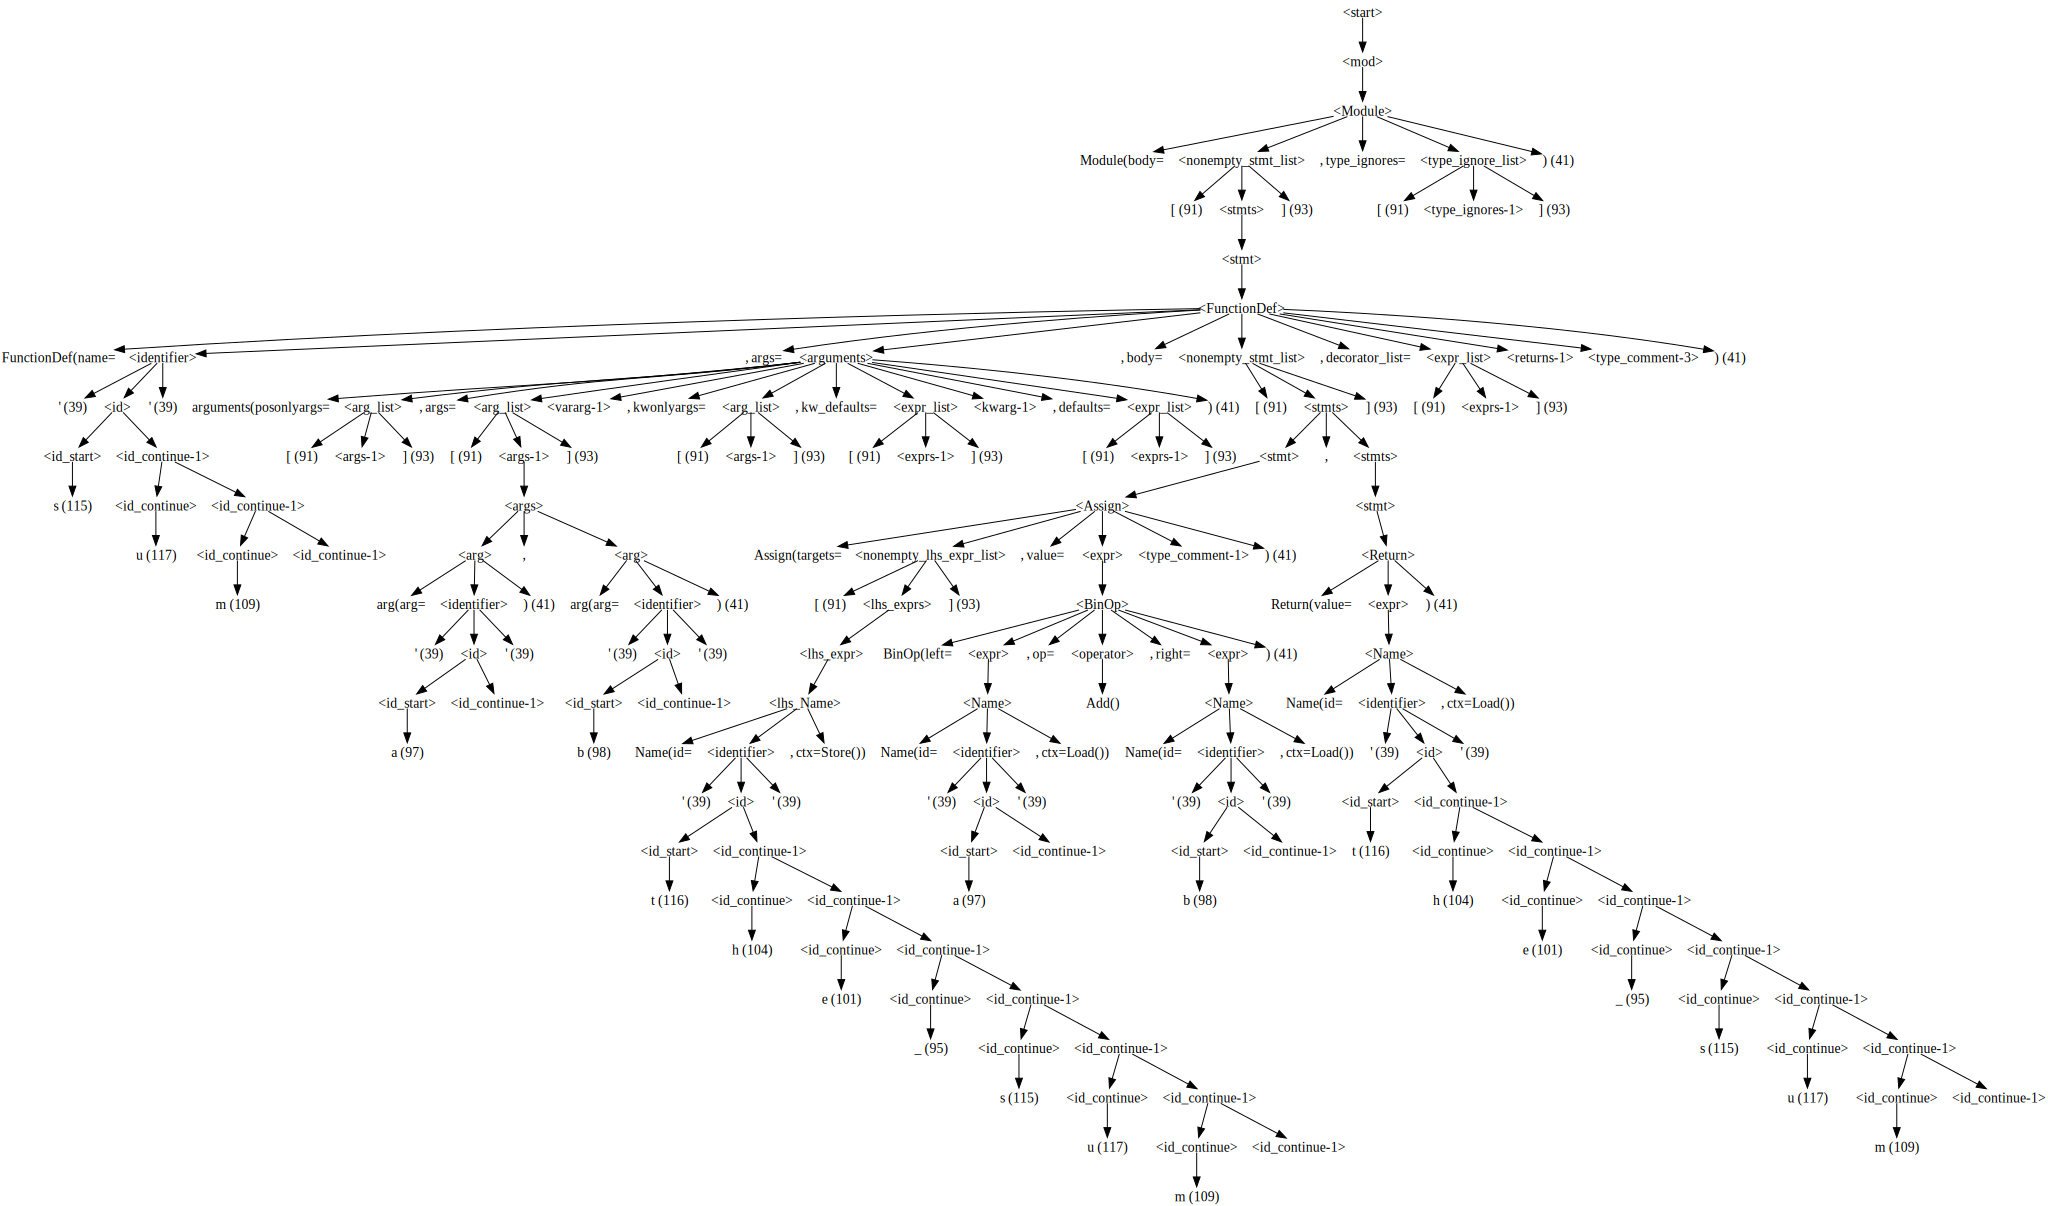

In [120]:
display_tree(sum_tree)

We see that a derivation tree consists of _nonterminal_ nodes whose children make up an _expansion_ from the grammar.
For instance, at the very top, we see that a `<start>` nonterminal expands into a `<mod>` nonterminal, which again expands into a `<Module>` nonterminal.
This comes right from the grammar rules

In [121]:
python_ast_grammar['<start>']

['<mod>']

and

In [122]:
python_ast_grammar['<mod>']

['<Module>']

The child of `<mod>` is a `<Module>`, which expands into the nodes

* `(body=`
* `<nonempty_stmt_list>`
* `, type_ignores=`
* `<type_ignore_list>`
* `)`

Here, nodes like `(body=` or `, type_ignores=` are called _terminal_ nodes (because they have no more elements to expand).
The nonterminals like `<nonempty_stmt_list>` get expanded further below – notably, `<nonempty_stmt_list>` expands into a `<FunctionDef>` node that represents the `sum()` definition.

Again, the structure exactly follows the `<Module>` definition in our grammar:

In [123]:
python_ast_grammar['<Module>']

['Module(body=<nonempty_stmt_list>, type_ignores=<type_ignore_list>)']

If we traverse the tree depth-first, left to right, and only collect the terminal symbols, we obtain the original string we parsed.
Applying the `str()` function to the derivation tree gets us exactly that string:

In [124]:
str(sum_tree)

"Module(body=[FunctionDef(name='sum', args=arguments(posonlyargs=[], args=[arg(arg='a'), arg(arg='b')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Assign(targets=[Name(id='the_sum', ctx=Store())], value=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load()))), Return(value=Name(id='the_sum', ctx=Load()))], decorator_list=[])], type_ignores=[])"

And again, we can convert this string into an AST and thus obtain our original function:

In [125]:
sum_ast = ast.fix_missing_locations(eval(str(sum_tree)))
print(ast.unparse(sum_ast))

def sum(a, b):
    the_sum = a + b
    return the_sum


### Mutating Inputs

With derivation trees, we can have a _structured_ representation of our input. In our case, we already have that with ASTs, so why bother introducing a new one? The answer is simple: Derivation trees also allow us to _synthesize_ new inputs, because we have a _grammar_ that describes their structure.

Most notably, we can mutate inputs as follows:

1. Parse the input into a derivation tree, as shown above.
2. Randomly choose some node `<symbol>` in the derivation tree to be mutated.
3. Use the grammar to produce a new expansion for `<symbol>`.
4. Replace the children of `<symbol>` by the expansion just generated.
5. Repeat the process as often as needed.

This is a decent programming task, and if you'd like a blueprint, have a look at the `FragmentMutator` in this tutorial on [greybox fuzzing with grammars](https://www.fuzzingbook.org/html/GreyboxGrammarFuzzer.html).

Fortunately, ISLa already provides us with functionality that does exactly this.
The `ISLaSolver.mutate()` method takes an input and mutates it according to the rules in the grammar.
The input to mutate can be given as a derivation tree, or as a string; its output is a derivation tree (which can again be converted into a string).

Let us apply `mutate()` on our `sum()` function. The `min_mutations` and `max_mutations` parameters define how many mutation steps should be performed; we set both to 1 in order to have exactly one mutation.

In [126]:
sum_mutated_tree = solver.mutate(sum_str, min_mutations=1, max_mutations=1)

In [127]:
sum_mutated_ast = ast.fix_missing_locations(eval(str(sum_mutated_tree)))
print(ast.unparse(sum_mutated_ast))

def sum(a, b):
    the_sum = a + b
    return iX


Toy with the above to see the effect of a mutation.
Note if one of the top-level nodes (like `<FunctionDef>` or `<Module>`) is selected for mutation, then `sum()` will be replaced by something entirely different. Otherwise, though, the code will still be pretty similar to the original `sum()` code.

Of course, the more we increase the number of mutations, the more different the code will look like:

In [128]:
sum_mutated_tree = solver.mutate(sum_str, min_mutations=10, max_mutations=20)

In [129]:
sum_mutated_ast = ast.fix_missing_locations(eval(str(sum_mutated_tree)))
print(ast.unparse(sum_mutated_ast))

def suaGysF9c4Uww(b, b):
    ([p[:]].ESL, *a[:][{set(): ()}.L_([set()], set()[:] + (not set()), ''):][:]) = h = aheuj_suGm + nHiZXdkWQJw7AjoUBmIb_qxCOfVmRz2pYrK6n9gDMh0cE43PTNve15tl
    return t


By toying with the `mutate()` parameters, we can control how _common_ and how _uncommon_ our input should be.

### How Effective is Mutation?

Does mutating existing code help us in finding bugs?
Let us assume we have a buggy compiler that generates bad code for an expression of the form `<elem> * (<elem> + <elem>)`.
The code in `has_distributive_law()` checks an AST for the presence of this bug:

In [130]:
def has_distributive_law(tree) -> bool:
    for node in walk(tree):  # iterate over all nodes in `tree`
        # print(node)
        if isinstance(node, ast.BinOp):
            if isinstance(node.op, ast.Mult):
                if isinstance(node.right, ast.BinOp):
                    if isinstance(node.right.op, ast.Add):
                        return True

                if isinstance(node.left, ast.BinOp):
                    if isinstance(node.left.op, ast.Add):
                        return True

    return False

To understand how this works, a visualization of the AST comes in handy:

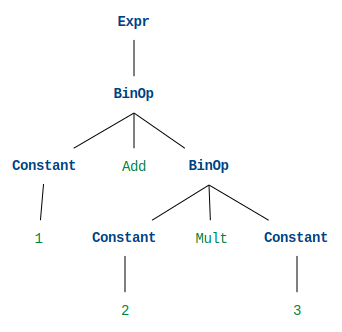

In [131]:
show_ast(ast.parse("1 + (2 * 3)"))

In [132]:
has_distributive_law(ast.parse("1 * (2 + 3)"))

True

In [133]:
has_distributive_law(ast.parse("(1 + 2) * 3"))

True

In [134]:
has_distributive_law(ast.parse("1 + (2 * 3)"))

False

In [135]:
has_distributive_law(ast.parse("def f(a, b):\n    return a * (b + 10)"))

True

How many attempts does it take for each until we find a mutation that triggers the bug in `has_distributive_law()`? 
Let us write a function that computes this number.

In [136]:
def how_many_mutations(code: str) -> int:
    solver = ISLaSolver(python_ast_grammar)

    code_ast = ast.parse(code)
    code_ast = ast.fix_missing_locations(code_ast)
    code_ast_str = ast.dump(code_ast)
    code_derivation_tree = solver.parse(code_ast_str)
    mutations = 0
    mutated_code_ast = code_ast

    while not has_distributive_law(mutated_code_ast):
        mutations += 1
        if mutations % 100 == 0:
            print(f'{mutations}...', end='')

        mutated_code_str = str(solver.mutate(code_derivation_tree))
        mutated_code_ast = eval(mutated_code_str)
        # mutated_code_ast = ast.fix_missing_locations(mutated_code_ast)
        # print(ast.dump(mutated_code_ast))
        # print(ast.unparse(mutated_code_ast))

    return mutations

If we pass an input that already exhibits the bug, we do not need any mutation:

In [137]:
assert how_many_mutations('1 * (2 + 3)') == 0

However, the further we are away from the bug, the more mutations (and the more time) it takes to find it.
Notably, mutating `2 + 2` until we have a distributive law still is much faster than mutating `2`.

In [138]:
how_many_mutations('2 + 2')    # <-- Note: this can take a minute

65

In [139]:
how_many_mutations('2')  # <-- Note: this can take several minutes

91

We conclude that mutating existing code can indeed be helpful, especially if it is syntactically _close to inputs that trigger bugs_.
If you want to have a good chance in finding bugs, focus on _inputs that have triggered bugs before_ – sometimes a simple mutation of these already helps finding a new bug.

## Evolutionary Fuzzing

One interesting application of mutating inputs is to use mutations for _evolutionary fuzzing_.
The idea is to have a population of inputs, to apply _mutations_ on them, and to check whether they improve on a particular goal (mostly code coverage).
Those inputs that _do_ improve are being retained ("survival of the fittest") as the next generation, and evolved further.
By repeating this process often enough, we may obtain inputs that cover large parts of code and thus improve chances to uncover bugs.

Let us assume we have a buggy compiler that generates bad code for an expression of the form `<elem> * (<elem> + <elem>)`.
The function `has_distributive_law()`, above, checks an AST for the presence of this bug.

Our aim is to detect this bug via fuzzing. But if we simply generate random inputs from scratch, it may take a long time until we generate the exact copmbination of operators that triggers the bug.

### Getting Coverage

To have our fuzzers guided by coverage, we first need to _measure_ code coverage.
We make use of the [Coverage module from the Fuzzing Book](https://www.fuzzingbook.org/html/Coverage.html), which is particularly easy to use.
It simply uses a `with` clause to obtain coverage from the code in the `with` body.
Here is how to obtain coverage for our `has_distributive_law()` code, above:

In [140]:
from Coverage import Coverage

In [141]:
mult_ast = ast.parse("1 * 2")
with Coverage() as cov:
    has_distributive_law(mult_ast)

The `coverage()` method tells us which lines in the code actually have been reached.
This includes lines from `has_distributive_law()`, but also lines from other functions called.

In [142]:
cov.coverage()

{('_handle_fromlist', 1063),
 ('_handle_fromlist', 1064),
 ('_handle_fromlist', 1071),
 ('_handle_fromlist', 1075),
 ('_handle_fromlist', 1087),
 ('has_distributive_law', 2),
 ('has_distributive_law', 4),
 ('has_distributive_law', 5),
 ('has_distributive_law', 6),
 ('has_distributive_law', 10),
 ('has_distributive_law', 14),
 ('iter_child_nodes', 264),
 ('iter_child_nodes', 265),
 ('iter_child_nodes', 266),
 ('iter_child_nodes', 267),
 ('iter_child_nodes', 268),
 ('iter_child_nodes', 269),
 ('iter_child_nodes', 270),
 ('iter_fields', 252),
 ('iter_fields', 253),
 ('iter_fields', 254),
 ('walk', 378),
 ('walk', 379),
 ('walk', 380),
 ('walk', 381),
 ('walk', 382),
 ('walk', 383)}

Which are the lines executed? 
With a bit of code inspection, we can easily visualize the covered lines:

In [143]:
def show_coverage(cov, fun):
    fun_lines, fun_start = inspect.getsourcelines(fun)
    fun_name = fun.__name__
    coverage = cov.coverage()
    for line in range(len(fun_lines)):
        if (fun_name, line + fun_start) in coverage:
            print('# ', end='')  # covered lines
        else:
            print('  ', end='')  # uncovered lines
        print(line + fun_start, fun_lines[line], end='')

In [144]:
show_coverage(cov, has_distributive_law)

  1 def has_distributive_law(tree) -> bool:
# 2     for node in walk(tree):  # iterate over all nodes in `tree`
  3         # print(node)
# 4         if isinstance(node, ast.BinOp):
# 5             if isinstance(node.op, ast.Mult):
# 6                 if isinstance(node.right, ast.BinOp):
  7                     if isinstance(node.right.op, ast.Add):
  8                         return True
  9 
# 10                 if isinstance(node.left, ast.BinOp):
  11                     if isinstance(node.left.op, ast.Add):
  12                         return True
  13 
# 14     return False


In this listing, a `#` indicates that the code has been executed (covered).
We see that our input "1 * 2" satisfies the conditions in Lines 4 and 5, but does not satisfy the conditions in later lines.

### Fitness

Let us now use coverage as a _fitness function_ to guide evolution.
The higher the fitness (the coverage), the higher the chances of an input to be retained for further evolution.
Our `ast_fitness()` function simply counts the number of lines covered in `has_distributive_law()`.

In [145]:
def ast_fitness(code_ast) -> int:
    with Coverage() as cov:
        has_distributive_law(code_ast)
    lines = set()
    for (name, line) in cov.coverage():
        if name == has_distributive_law.__name__:
            lines.add(line)
    return len(lines)

Here is the fitness of a number of given inputs:

In [146]:
ast_fitness(ast.parse("1"))

3

In [147]:
ast_fitness(ast.parse("1 + 1"))

4

In [148]:
ast_fitness(ast.parse("1 * 2"))

6

In [149]:
ast_fitness(ast.parse("1 * (2 + 3)"))

6

Now, let's set up a fitness function that takes derivation trees.
Essentially, our `tree_fitness()` function is based on the `ast_fitness()` function, above;
however, we also add a small component `1 / len(code_str)` to give extra fitness to shorter inputs.
Otherwise, our inputs may grow and keep on growing, making mutations inefficient.

In [150]:
def tree_fitness(tree) -> float:
    code_str = str(tree)
    code_ast = ast.fix_missing_locations(eval(code_str))
    fitness = ast_fitness(code_ast)
    # print(ast.unparse(code_ast), f"\n=> Fitness = {fitness}\n")
    return fitness + 1 / len(code_str)

In [151]:
tree_fitness(sum_tree)

4.002666666666666

### Evolving Inputs

Let us now make use of our fitness function to implement a simple evolutionary fuzzing algorithm.
We start with _evolution_ – that is, taking a population and adding offspring via mutations.
Our initial population consists of a single candidate – in our case, `sum_tree` reflecting the `sum()` function, above.

In [152]:
def initial_population(tree):
    return [ (tree, tree_fitness(tree)) ]

In [153]:
sum_population = initial_population(sum_tree)

In [154]:
len(sum_population)

1

Our `evolve()` function adds two new children to each population member.

In [155]:
OFFSPRING = 2

In [156]:
def evolve(population, min_fitness=-1):
    solver = ISLaSolver(python_ast_grammar)

    for (candidate, _) in list(population):
        for i in range(OFFSPRING):
            child = solver.mutate(candidate, min_mutations=1, max_mutations=1)
            child_fitness = tree_fitness(child)
            if child_fitness > min_fitness:
                population.append((child, child_fitness))
    return population

In [157]:
sum_population = evolve(sum_population)
len(sum_population)

3

As we can evolve all these, too, we get an exponential growth.

In [158]:
sum_population = evolve(sum_population)
len(sum_population)

9

In [159]:
sum_population = evolve(sum_population)
len(sum_population)

27

In [160]:
sum_population = evolve(sum_population)
len(sum_population)

81

In [161]:
sum_population = evolve(sum_population)
len(sum_population)

243

### Survival of the Fittest

No population can expand forever and still survive.
Let us thus limit the population to a certain size.

In [162]:
POPULATION_SIZE = 100

The `select()` function implements survival of the fittest: It limits the population to at most `POPULATION_SIZE` elements, sorting them by their fitness (highest to lowest).
Members with low fitness beyond `POPULATION_SIZE` do not survive.

In [163]:
def get_fitness(elem):
    (candidate, fitness) = elem
    return fitness

def select(population):
    population = sorted(population, key=get_fitness, reverse=True)
    population = population[:POPULATION_SIZE]
    return population

We can use the following call to trim our `sum_population` to the fittest members:

In [164]:
sum_population = select(sum_population)
len(sum_population)

100

### Evolution

We now have everything in place:

* We have a _population_ (say, `sum_population`)
* We can evolve the population (using `evolve()`)
* We can have only the fittest survive (using `select()`)

Let us repeat this process over several generations.
We track whenever we have found a new "best" candidate and log them.
If we find a candidate that triggers the bug, we stop.
Note that this may take a long time, and not necessarily yield a perfect result.

As common in search-based approaches, we stop and restart the search if we have not found a sufficient solution after a number of generations (here: `GENERATIONS`).
Other than that, we keep searching until we have a solution.

In [165]:
GENERATIONS = 100  # Upper bound

In [166]:
trial = 1
found = False

while not found:
    sum_population = initial_population(sum_tree)
    prev_best_fitness = -1

    for generation in range(GENERATIONS):
        sum_population = evolve(sum_population, min_fitness=prev_best_fitness)
        sum_population = select(sum_population)
        best_candidate, best_fitness = sum_population[0]
        if best_fitness > prev_best_fitness:
            print(f"Generation {generation}: found new best candidate (fitness={best_fitness}):")
            best_ast = ast.fix_missing_locations(eval(str(best_candidate)))
            print(ast.unparse(best_ast))
            prev_best_fitness = best_fitness

            if has_distributive_law(best_ast):
                print("Done!")
                found = True
                break

    trial = trial + 1
    print(f"\n\nRestarting; trial #{trial}")

Generation 0: found new best candidate (fitness=4.002673796791444):
def sum(a, b):
    the_sum = a + b
    return the_su
Generation 1: found new best candidate (fitness=4.002695417789758):
def sum(a, b):
    thK = a + the_sum
    return b
Generation 5: found new best candidate (fitness=4.002770083102493):
def sum(q):
    the_sum = a + the_sum
    return b
Generation 8: found new best candidate (fitness=4.003039513677812):
def sum(q):
    the_sum = a + the_sum
    pass
Generation 9: found new best candidate (fitness=6.001290322580645):
def sum(a, b):
    for JQ in 
    {} * set(): # type: 
        the_sum = a + b
        return the_su
    u = *q = ~() # type: 
    continue
Generation 22: found new best candidate (fitness=6.001426533523538):
if Q():
    with :
        pass
    return
else:

    def sum(a, b):
        the_sum = a + b
        return the_sum
    while set() * set():
        continue
        break
Generation 26: found new best candidate (fitness=6.001432664756447):
if Q():
 

Success! We found a piece of code that triggers the bug. Check for occurrences of the distributive law.

In [167]:
print(ast.unparse(best_ast))

def sum(a, b):
    h = (
    set() // *()) * (a + b)
    return t5


In [168]:
assert has_distributive_law(best_ast)


You may note that not all of the code is required to trigger the bug.
We could run our evolutionary fuzzer a bit longer to see whether it can be further reduced,
or use a dedicated input reduction technique such as [Delta Debugging](https://www.fuzzingbook.org/html/Reducer.html).

### Chances of Evolutionary Fuzzing

Could the bug in `distributive_law()` have been found without evolutionary guidance - i.e., simply by applying one mutation to `sum()`?

When producing an expression (`<expr>`), we calculate how big the chances are to

* Produce a binary operator, and
* Produce a `*`, and
* Produce another binary operator as one child, and
* Produce a `+`

Let's do a few queries on our grammar to compute the chances.

In [169]:
assert '<BinOp>' in python_ast_grammar['<expr>']

In [170]:
len(python_ast_grammar['<expr>'])

15

In [171]:
assert 'Add()' in python_ast_grammar['<operator>']
assert 'Mult()' in python_ast_grammar['<operator>']

In [172]:
len(python_ast_grammar['<operator>'])

13

In [173]:
(len(python_ast_grammar['<expr>'])       # chances of choosing a `BinOp`
* len(python_ast_grammar['<operator>'])  # chances of choosing a `*`
* len(python_ast_grammar['<expr>'])      # chances of choosing a `BinOp` as a child
* len(python_ast_grammar['<operator>'])  # chances of choosing a `+`
/ 2)   # two chances - one for the left child, one for the right

19012.5

On average, it would take about 19000 (non-evolutionary) runs until we have an expression that triggers the distributive law.
So it is definitely better to make use of additional information (say, coverage) in order to guide mutations towards a goal.

## Synopsis

This chapter provides a `PythonFuzzer` class that allows producing arbitrary Python code elements:

In [174]:
fuzzer = PythonFuzzer()
print(fuzzer.fuzz())

def Hw(): # type: 
    pass


By default, `PythonFuzzer` produces a _function definition_ – that is, a list of statements as above.
You can pass a `start_symbol` argument to state which Python element you'd like to have:

In [175]:
fuzzer = PythonFuzzer('<While>')
print(fuzzer.fuzz())

while 
'' or {Z: *(set() ^ set())}:
    del 


Here is a list of all possible start symbols. Their names reflect the nonterminals from the [Python `ast` module documentation](https://docs.python.org/3/library/ast.html).

In [176]:
sorted(list(PYTHON_AST_GRAMMAR.keys()))

['<Assert>',
 '<Assign>',
 '<Attribute>',
 '<AugAssign>',
 '<BinOp>',
 '<BoolOp>',
 '<Break>',
 '<Call>',
 '<Compare>',
 '<Constant>',
 '<Continue>',
 '<Delete>',
 '<Dict>',
 '<EmptySet>',
 '<Expr>',
 '<For>',
 '<FunctionDef>',
 '<If>',
 '<List>',
 '<Module>',
 '<Name>',
 '<Pass>',
 '<Return>',
 '<Set>',
 '<Slice>',
 '<Starred>',
 '<Subscript>',
 '<Tuple>',
 '<UnaryOp>',
 '<While>',
 '<With>',
 '<arg>',
 '<arg_list>',
 '<args>',
 '<arguments>',
 '<bool>',
 '<boolop>',
 '<cmpop>',
 '<cmpop_list>',
 '<cmpops>',
 '<digit>',
 '<digits>',
 '<expr>',
 '<expr_list>',
 '<exprs>',
 '<float>',
 '<func>',
 '<id>',
 '<id_continue>',
 '<id_start>',
 '<identifier>',
 '<integer>',
 '<keyword>',
 '<keyword_list>',
 '<keywords>',
 '<kwarg>',
 '<lhs_Attribute>',
 '<lhs_List>',
 '<lhs_Name>',
 '<lhs_Starred>',
 '<lhs_Subscript>',
 '<lhs_Tuple>',
 '<lhs_expr>',
 '<lhs_exprs>',
 '<literal>',
 '<mod>',
 '<none>',
 '<nonempty_expr_list>',
 '<nonempty_lhs_expr_list>',
 '<nonempty_stmt_list>',
 '<nonzerodigit>

If you'd like more control over Python code generation, here is what is happening behind the scenes.
The EBNF grammar `PYTHON_AST_GRAMMAR` can parse and produce _abstract syntax trees_ for Python.
To produce a Python module without `PythonFuzzer`, you would take these steps:

**Step 1:** Create a non-EBNF grammar suitable for `ISLaSolver` (or any other grammar fuzzer):

In [177]:
python_ast_grammar = convert_ebnf_grammar(PYTHON_AST_GRAMMAR)

**Step 2:**  Feed the resulting grammar into a grammar fuzzer such as ISLa:

In [178]:
solver = ISLaSolver(python_ast_grammar, start_symbol='<FunctionDef>')

**Step 3:**  Have the grammar fuzzer produce a string. This string represents an AST.

In [179]:
ast_string = str(solver.solve())
ast_string

'FunctionDef(name=\'t\', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Break()], decorator_list=[], returns=Call(func=Name(id="set", ctx=Load()), args=[], keywords=[]), type_comment=\'\')'

**Step 4:**  Convert the AST into an actual Python AST data structure.

In [180]:
from ast import *

In [181]:
abstract_syntax_tree = eval(ast_string)

**Step 5:** Finally, convert the AST structure back into readable Python code:

In [182]:
ast.fix_missing_locations(abstract_syntax_tree)
print(ast.unparse(abstract_syntax_tree))

def t() -> set(): # type: 
    break


The chapter has many more applications, including parsing and mutating Python code, evolutionary fuzzing, and more.

Here are the details on the `PythonFuzzer` constructor:

In [183]:
# ignore
import inspect
import markdown
from bookutils import HTML

In [184]:
# ignore
sig = inspect.signature(PythonFuzzer.__init__)
sig_str = str(sig) if sig else ""
doc = inspect.getdoc(PythonFuzzer.__init__) or ""
HTML(markdown.markdown('`PythonFuzzer' + sig_str + '`\n\n' + doc))

In [185]:
# ignore
from ClassDiagram import display_class_hierarchy

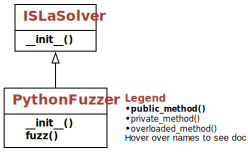

In [186]:
# ignore
display_class_hierarchy([PythonFuzzer],
                        public_methods=[
                            PythonFuzzer.__init__,
                            PythonFuzzer.fuzz,
                            ISLaSolver.__init__
                        ],
                        project='fuzzingbook')

## Lessons Learned

* When creating and processing complex inputs such as program code,
  * try to rely on existing infrastructure to _parse_ inputs into some _abstract syntax_, and then
  * have your grammars _process that abstract syntax_ rather than the concrete syntax.
* Specifically, program code is normally converted into _abstract syntax trees_ before being compiled or interpreted, and you can (and should) make use of such conversions.
* Once program code is turned into an AST, it is fairly easy to generate, mutate, and evolve despite its complexity.

## Background

The seminal work on compiler testing is _Csmith_ \cite{Yang2011}, a generator of C programs.
Csmith has been used to thoroughly test compilers such as Clang or GCC; beyond producing code that is syntactically correct, it also aims at _semantic_ correctness as well as avoiding undefined and unspecified behaviors.
This is a must read for anyone in the field in compiler testing.